# librosa
***

### 1. 載入套件

`pip3 install librosa`

In [1]:
import librosa
import numpy as np
from IPython.display import Audio  #播放套件
import matplotlib.pyplot as plt 
import librosa.display  #libroso 繪圖

### 2.匯入音檔 ＆ 播放

In [2]:
#使用內建音檔 librosa.example()查看其他音檔
# y, sr = librosa.load(librosa.ex('brahms'), duration=20) # duration = 秒數

#載入音檔，給檔案路徑
y, sr = librosa.load('/Volumes/Extreme SSD/musicfile/3s/blues/blues5-1-0.wav', sr=22050, duration=60) #sr:採樣率 (一般音樂 44100Hz/s ,官方建議用 22050分析資料 )

#試聽音檔
Audio(data=y, rate=sr)

### 3.繪製波形圖

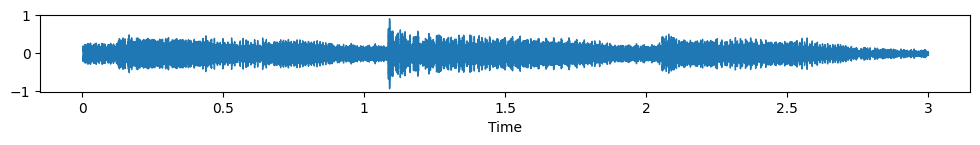

In [3]:
fig, ax = plt.subplots(sharex=True, figsize=(12,1))  # matplotlib 開圖面
librosa.display.waveshow(y, sr=sr)  # 波形繪製

### 4.光譜圖  Ex: Short-time Fourier transform (STFT) 短時傅立葉轉換)

In [4]:
STFT = librosa.stft(y=y)

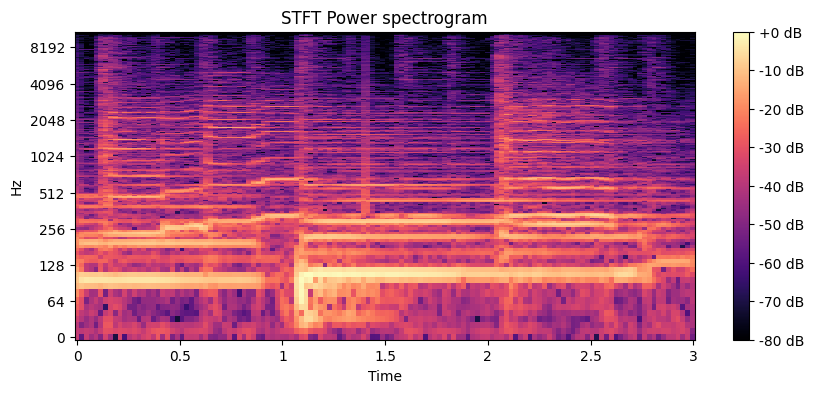

In [5]:
fig, ax = plt.subplots(figsize=(10,4))
STFT_abs = np.abs(STFT)   # STFT 取絕對值

# librosa.display 繪製光譜圖，搭配 matplotlib 套件繪製。
img = librosa.display.specshow(librosa.amplitude_to_db(STFT_abs,ref=np.max), # ampltude_to_db() 振幅轉分貝
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('STFT Power spectrogram') # 標題
fig.colorbar(img, ax=ax, format="%+2.0f dB") # 分貝標示

---

# 特徵提取

## `Beat & tempo` 偵測節拍特徵 


* _`librosa.beat.beat_track`_ 
>1. beat: 節拍出現的 frame編號（時間點）
>2. temp: 節奏頻率 （次/分鐘）

In [6]:
# 偵測節拍，輸出兩個變數
# ----- y:音訊資料點, sr:採樣率, hop_length(不寫預設 512)-----
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr, hop_length=512) 
print(tempo)
print(beat_frames) # array 

61.5234375
[ 7 48]


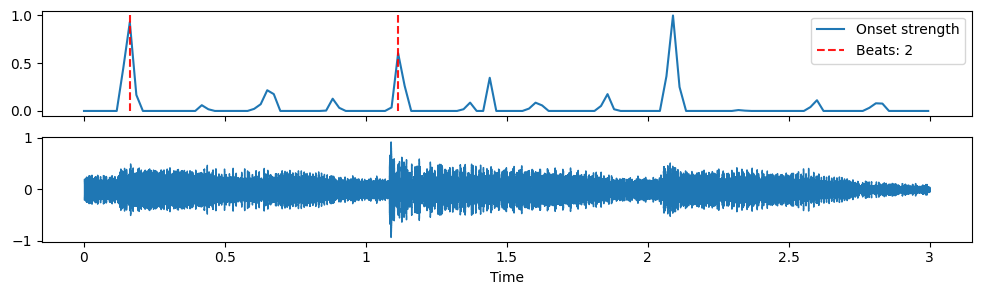

In [7]:
hop_length = 512 # 預設 512
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median) # 取光譜強度值
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length) # 取出時間資訊

# 開兩張圖對比
fig, ax = plt.subplots(nrows=2, sharex=True ,figsize=(12,3)) # 開兩張畫布
ax[0].plot(times, librosa.util.normalize(onset_env),label='Onset strength') # 將 onset_env value 正歸化成 0~1 範圍
ax[0].vlines(times[beat_frames], 0, 1, alpha=0.9, color='r',linestyle='--', label='Beats: '+str(len(beat_frames)))
librosa.display.waveshow(y, sr=sr,ax=ax[1]) # 第二張波形圖
ax[0].legend() # 加上標籤

---

## `Chroma 色度特徵`（表示每個八度音階的強度 C: "Do" , D: "Re" , E: "Mi"......）

1. _`librosa.feature.chroma_stft`_ 音階色譜

In [8]:
S = np.abs(librosa.stft(y)) # 先轉為 stft
chroma_stft = librosa.feature.chroma_stft(S=S, sr=sr) 

2. _`librosa.feature.chroma_cqt`_ Q常數音階色譜

In [9]:
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

3. _`librosa.feature.chroma_cens`_ 正規化音階色譜

In [10]:
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

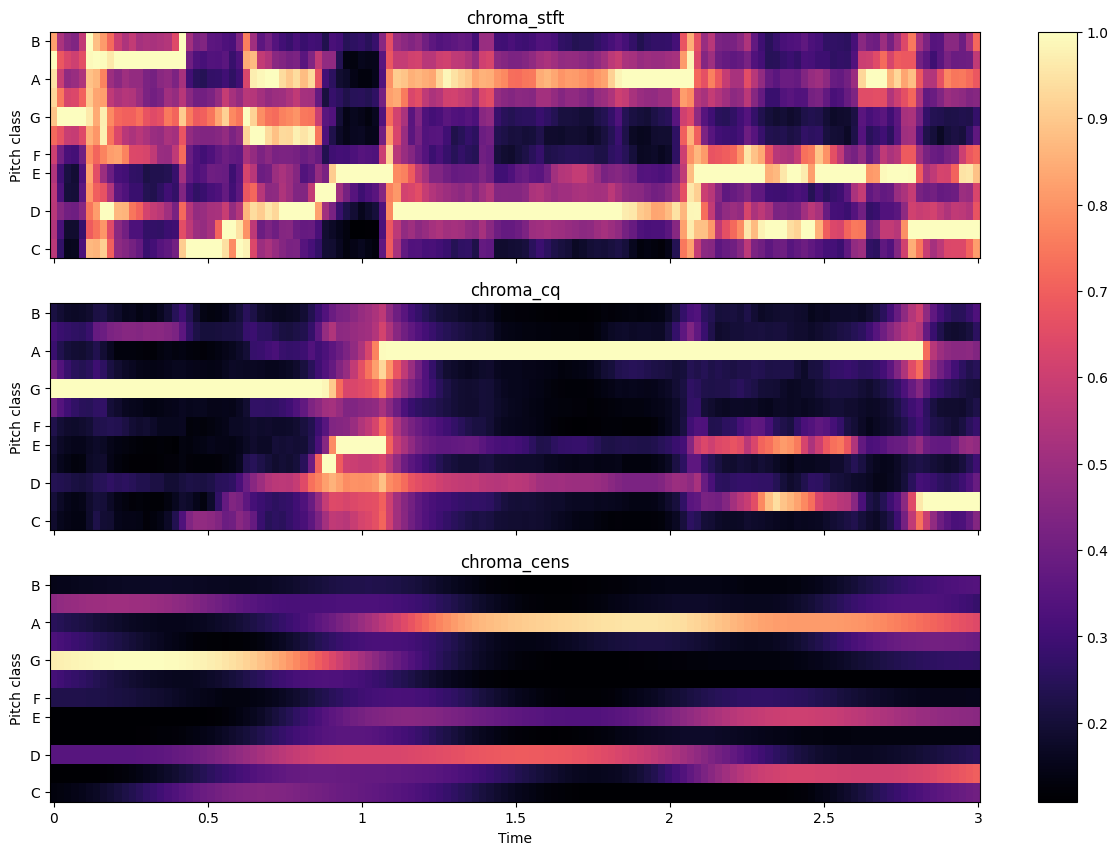

In [11]:
fig, ax = plt.subplots(nrows=3,ncols=1, sharex=True, sharey=True, figsize=(15, 10))
img = librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', ax=ax[0])
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time', ax=ax[1])
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time', ax=ax[2])
ax[0].label_outer()
ax[1].label_outer()
ax[0].set(title='chroma_stft')
ax[1].set(title='chroma_cq')
ax[2].set(title='chroma_cens')
fig.colorbar(img, ax=ax)

---

## Ｍel-spectrogram 梅爾尺度光譜 ＆ MFCC 梅爾倒頻係數

* _`librosa.feature.melspectrogram`_

In [12]:
S = np.abs(librosa.stft(y))
melspectrogram = librosa.feature.melspectrogram(S=S, sr=sr)
melspectrogram.shape

(128, 130)

* _`librosa.feature.mfcc`_

In [13]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20) # n_mfcc 數量
mfccs.shape # 20個有 130值的 numpy.arrary, 130值：音檔時間越長個數越多

(20, 130)

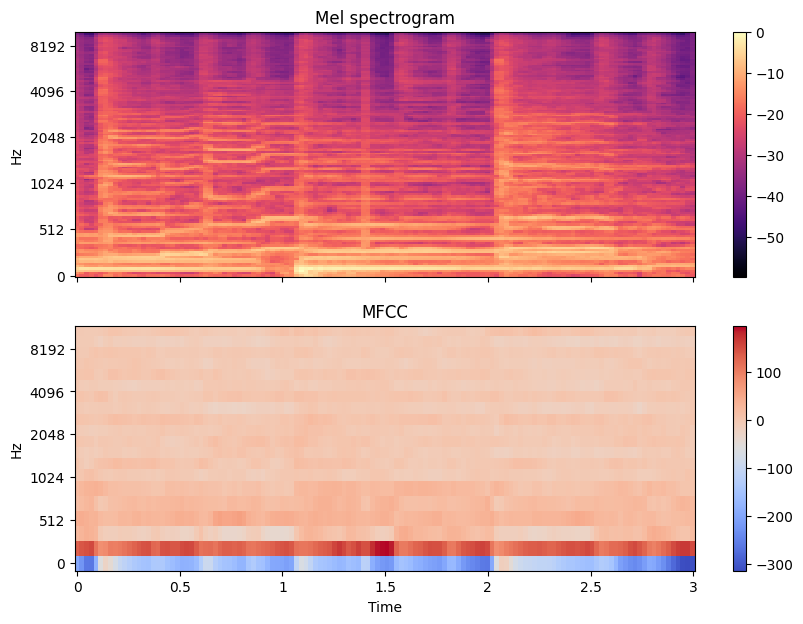

In [14]:
fig, ax = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 7))
img_mel = librosa.display.specshow(librosa.power_to_db(melspectrogram, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=10000, ax=ax[0])
img_mfcc= librosa.display.specshow(mfccs, x_axis='time',y_axis='mel', ax=ax[1])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].set(title='MFCC')
fig.colorbar(img_mel, ax=[ax[0]])
fig.colorbar(img_mfcc, ax=[ax[1]])

---

## RMS 均方根特徵

* _`librosa.feature.rms`_
>使用時間序列值_`y`_ 或頻譜值_`S`_, 的計算每幀的均方根。

In [15]:
rms = librosa.feature.rms(y=y)
rms.shape

(1, 130)

[Text(0.5, 1.0, 'STFT log Power spectrogram')]

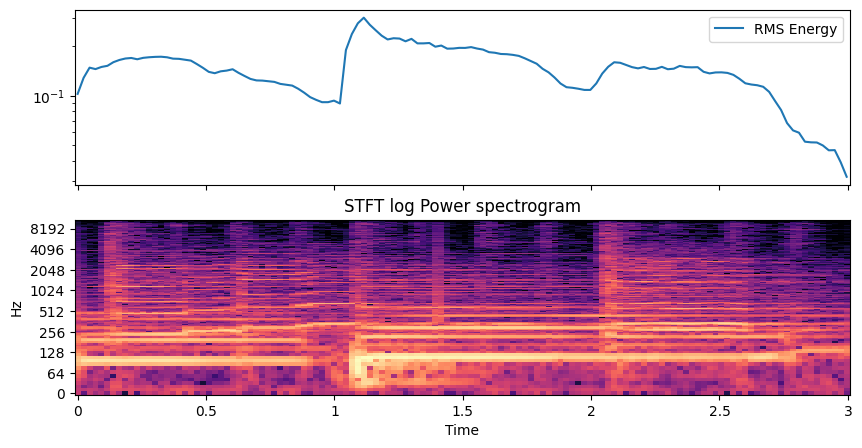

In [17]:
times = librosa.times_like(rms)  # 提取時間
S, phase = librosa.magphase(librosa.stft(y))  # 只取 S,  (D = S*P )

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,5))
ax[0].semilogy(times, rms[0], label='RMS Energy')   # rms => (1, 130), rms[0] => (130,)
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='STFT log Power spectrogram')

---

## spectral_centroid 光譜質心 （平均值）

* _`librosa.spectral_centroid`_
>每幀頻譜振幅的正規化和頻率區間上的分佈，從每一幀提取平均值。<br>
: 輸入時間序列、頻譜（stft -> magphase）

In [34]:
# 方法1. 使用時間序列計算
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
cent.shape

(1, 130)

In [40]:
# 方法2. 使用頻譜計算
D = librosa.stft(y)  # stft
S, phase = librosa.magphase(D)  # 只取 S,  (D = S*P )
cent1 = librosa.feature.spectral_centroid(S=S)
cent1.shape  #結果一樣

(1, 130)

[Text(0.5, 1.0, 'log Power spectrogram')]

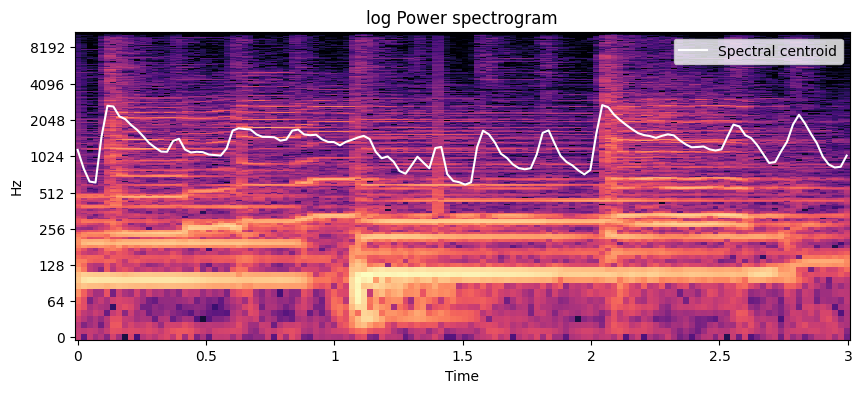

In [54]:
times = librosa.times_like(cent) # 提取時間
fig, ax = plt.subplots(figsize=(10,4)) # 開圖面設定大小
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, cent[0], label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')

---

## tonnetz 三個調性強度

* _`librosa.feature.tonnetz`_
>將 **`chroma色度特徵`** 投影，純五度、小三度、大三度分別表示到二維資料。 <br>
  ----> _分析音訊什麼調性較強_

In [18]:
# y = librosa.effects.harmonic(y)  # 從時間序列中提取諧波元素
tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

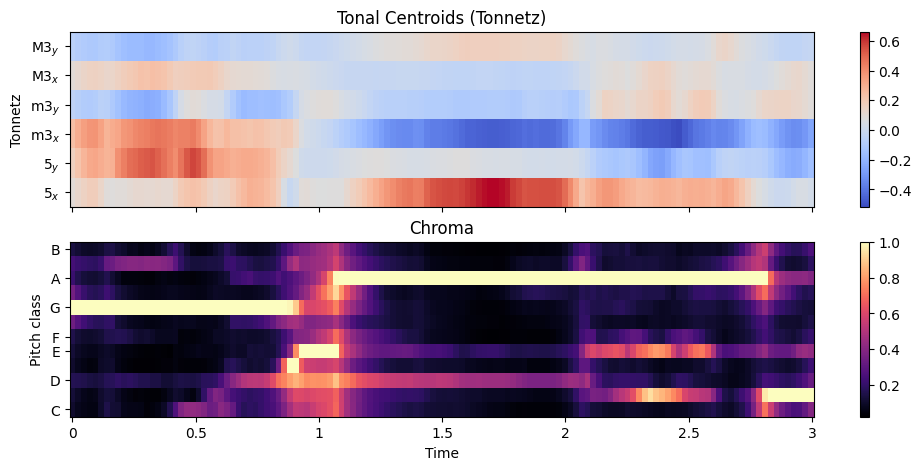

In [19]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12,5))
img1 = librosa.display.specshow(tonnetz,
                                y_axis='tonnetz', x_axis='time', ax=ax[0])
img2 = librosa.display.specshow(librosa.feature.chroma_cqt(y=y, sr=sr),
                                y_axis='chroma', x_axis='time', ax=ax[1])
ax[0].set(title='Tonal Centroids (Tonnetz)')
ax[0].label_outer()
ax[1].set(title='Chroma')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])

---

## zero_crossing_rate 過零率

* _`librosa.feature.zero_crossing_rate`_

In [20]:
zcr = librosa.feature.zero_crossing_rate(y=y)

In [21]:
zcr.shape

(1, 130)

---

## effects.harmonic 諧波特徵

* _`ibrosa.effects.harmonic`_

In [109]:
y_harmonic = librosa.effects.harmonic(y)
y_harmonic.shape

(66150,)

In [120]:
# Use a margin > 1.0 for greater harmonic separation 使用更大的諧波分離
y_harmonic_m = librosa.effects.harmonic(y, margin=5.0)
y_harmonic_m.shape

(66150,)

In [148]:
# 原始音檔播放
Audio(data=y, rate=sr)

In [149]:
# 諧波處理後音檔播放
# Audio(data=y_harmonic, rate=sr)
Audio(data=y_harmonic_m, rate=sr) # 更大的諧波分離

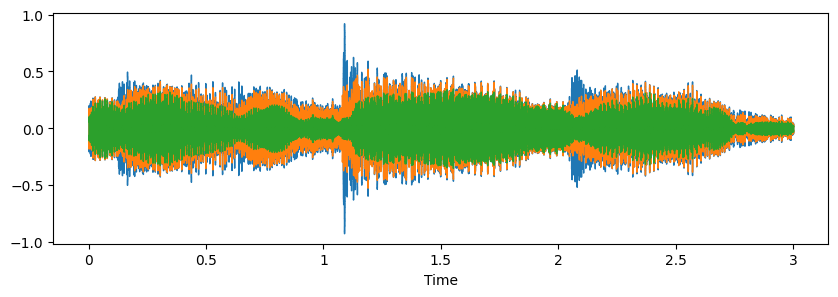

In [154]:
fig, ax = plt.subplots(figsize=(10,3))
librosa.display.waveshow(y, sr=sr, ax=ax, label='Spectral centroid')
librosa.display.waveshow(y_harmonic, sr=sr, ax=ax ,alpha=1)
librosa.display.waveshow(y_harmonic_m, sr=sr, ax=ax, alpha=1)

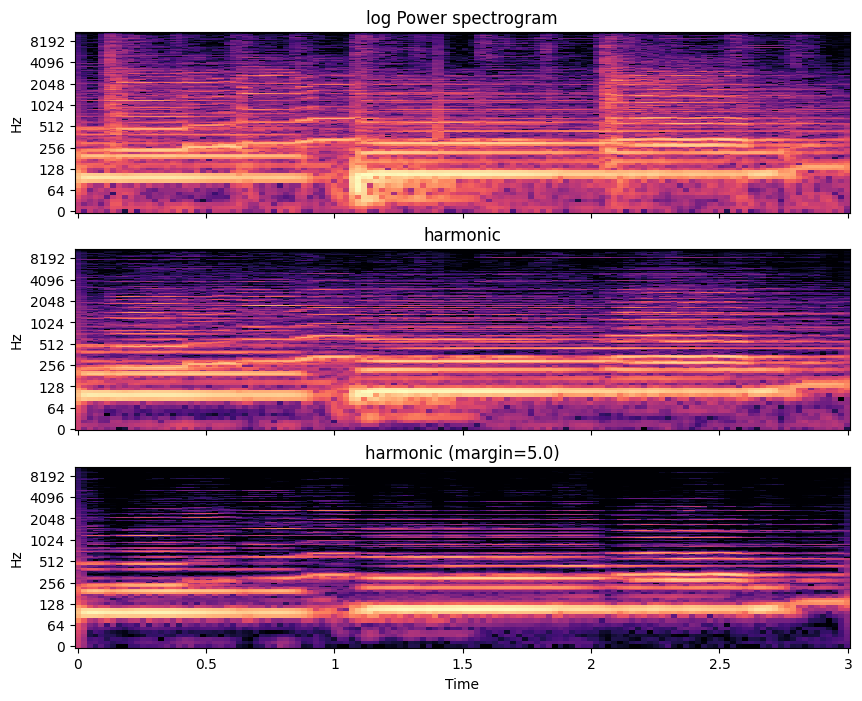

In [121]:
ys_harmonic = librosa.stft(y_harmonic)
ys_harmonic_m = librosa.stft(y_harmonic_m)
fig, ax = plt.subplots(nrows = 3, figsize=(10,8))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
librosa.display.specshow(librosa.amplitude_to_db(np.abs(ys_harmonic), ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
librosa.display.specshow(librosa.amplitude_to_db(np.abs(ys_harmonic_m), ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[2])
ax[0].set(title='log Power spectrogram')
ax[1].set(title='harmonic')
ax[2].set(title='harmonic (margin=5.0)')
ax[0].label_outer()
ax[1].label_outer()

---

## effects.percussive 打擊特徵

* _`ibrosa.effects.percussive`_

In [122]:
y_percussive = librosa.effects.percussive(y)

In [123]:
y_percussive_m = librosa.effects.percussive(y, margin=3.0) #使用更大的效果

In [150]:
# 原始音檔播放
Audio(data=y, rate=sr)

In [152]:
# 打擊特徵分離後音檔播放
# Audio(data=y_percussive, rate=sr)
Audio(data=y_percussive_m, rate=sr) #使用更大的效果

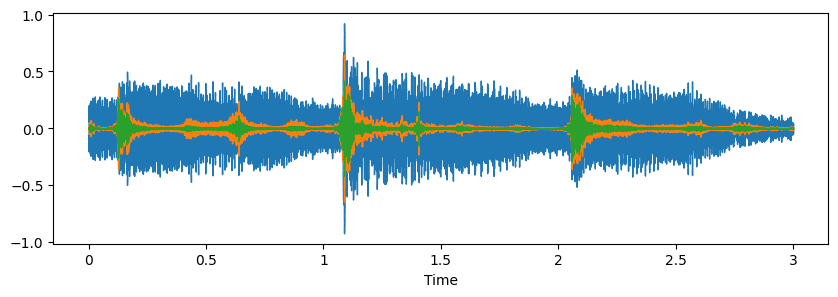

In [153]:
fig, ax = plt.subplots(figsize=(10,3))
librosa.display.waveshow(y, sr=sr, ax=ax)
librosa.display.waveshow(y_percussive, sr=sr, ax=ax ,alpha=1)
librosa.display.waveshow(y_percussive_m, sr=sr, ax=ax, alpha=1)

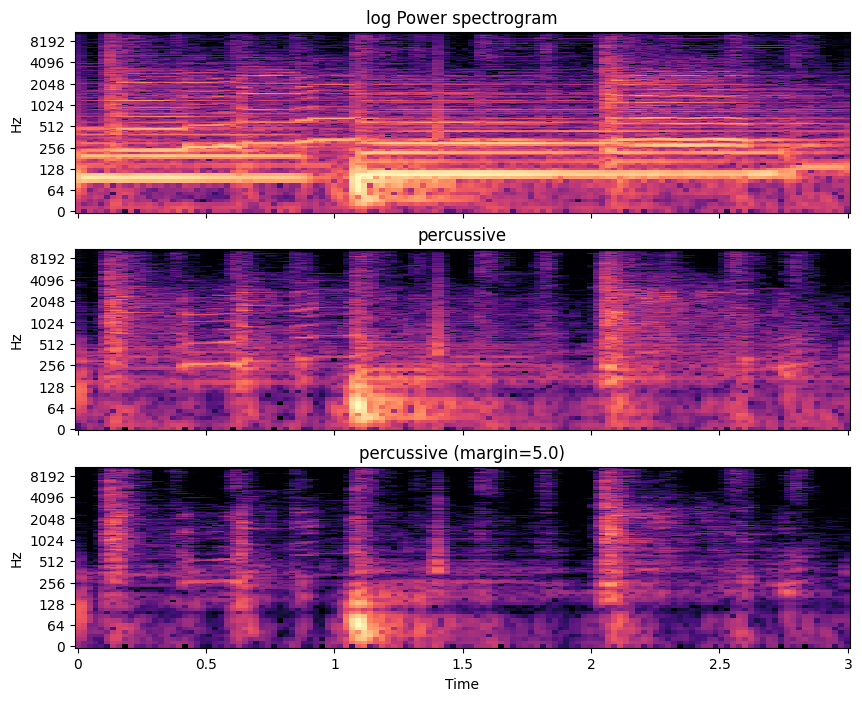

In [124]:
ys_percussive = librosa.stft(y_percussive)
ys_percussive_m = librosa.stft(y_percussive_m)
fig, ax = plt.subplots(nrows = 3, figsize=(10,8))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
librosa.display.specshow(librosa.amplitude_to_db(np.abs(ys_percussive), ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
librosa.display.specshow(librosa.amplitude_to_db(np.abs(ys_percussive_m), ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[2])
ax[0].set(title='log Power spectrogram')
ax[1].set(title='percussive')
ax[2].set(title='percussive (margin=5.0)')
ax[0].label_outer()
ax[1].label_outer()

---

## spectral_rolloff 滾降頻率範圍

* _`ibrosa.spectral_rolloff`_
>roll_percet 範圍值 0 ~ 1 , default(0.85)

In [22]:
# 近似最大頻率滾降百分比 =0.85 (default)
rolloff_def = librosa.feature.spectral_rolloff(y=y, sr=sr)

In [23]:
# 近似最大頻率滾降百分比 =0.99
rolloff_max = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)

In [24]:
# 近似最小頻率滾降百分比 =0.01
rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

[Text(0.5, 1.0, 'log Power spectrogram')]

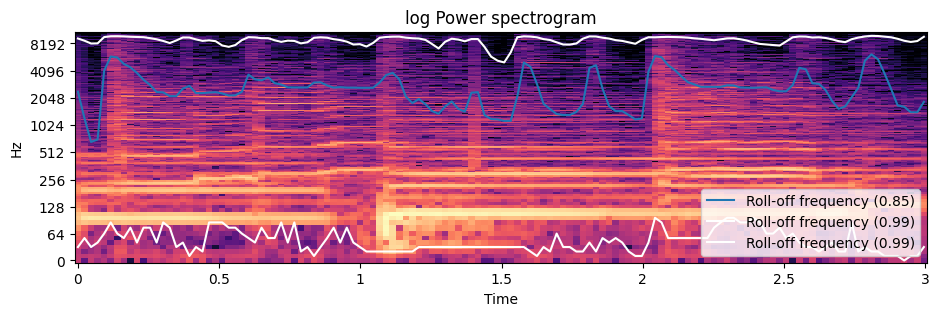

In [25]:
S, phase = librosa.magphase(librosa.stft(y)) # stft處理 -> 拆分振幅和相位
fig, ax = plt.subplots(figsize=(11,3))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(librosa.times_like(rolloff_def), rolloff_def[0], label='Roll-off frequency (0.85)')
ax.plot(librosa.times_like(rolloff_max), rolloff_max[0], label='Roll-off frequency (0.99)',color='w')
ax.plot(librosa.times_like(rolloff_min), rolloff_min[0], label='Roll-off frequency (0.99)',color='w')

ax.legend(loc='lower right')
ax.set(title='log Power spectrogram')

---

## poly_features 聚合特徵

* _`poly_features`_

In [88]:
S = np.abs(librosa.stft(y))
p0 = librosa.feature.poly_features(S=S)
p1 = librosa.feature.poly_features(S=S, order=1)
p2 = librosa.feature.poly_features(S=S, order=2)

In [89]:
print(p0.shape)
print(p1.shape)
print(p2.shape)

(2, 130)
(2, 130)
(3, 130)


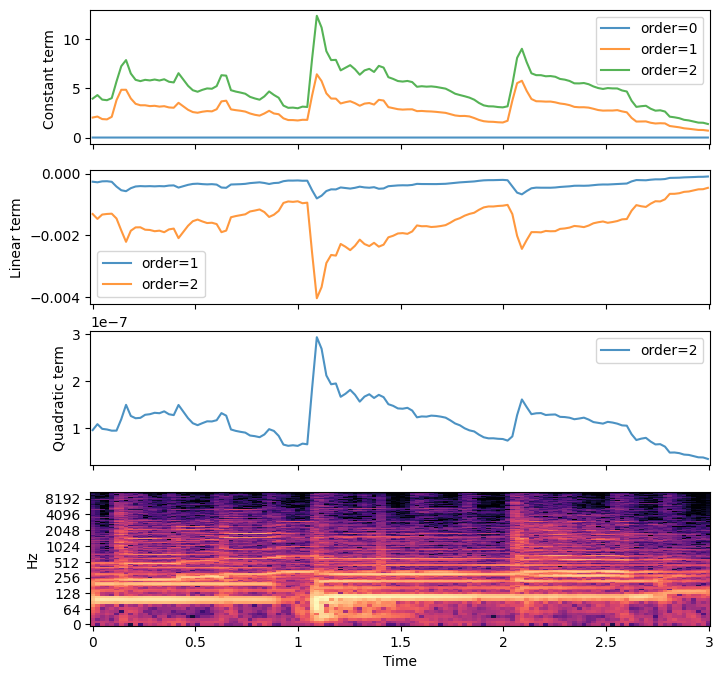

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
times = librosa.times_like(p0)
ax[0].plot(times, p0[0], label='order=0', alpha=0.8)
ax[0].plot(times, p1[1], label='order=1', alpha=0.8)
ax[0].plot(times, p2[2], label='order=2', alpha=0.8)
ax[0].legend()
ax[0].label_outer()
ax[0].set(ylabel='Constant term ')
ax[1].plot(times, p1[0], label='order=1', alpha=0.8)
ax[1].plot(times, p2[1], label='order=2', alpha=0.8)
ax[1].set(ylabel='Linear term')
ax[1].label_outer()
ax[1].legend()
ax[2].plot(times, p2[0], label='order=2', alpha=0.8)
ax[2].set(ylabel='Quadratic term')
ax[2].legend()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[3])